In [ ]:
!pip install transformers sentence-transformers


KeyboardInterrupt: 

In [1]:
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving fuzzy_terms_.csv to fuzzy_terms_.csv


In [ ]:
df = pd.read_csv("Clinical Normalization Models.csv")
input_terms = df["Term"].tolist()
ground_truth = df["concept_name"].tolist()

models = {
    "SapBERT": "cambridgeltl/SapBERT-from-PubMedBERT-fulltext",
    "BioBERT": "dmis-lab/biobert-base-cased-v1.1"
}

tokenizers = {name: AutoTokenizer.from_pretrained(path) for name, path in models.items()}
models = {name: AutoModel.from_pretrained(path) for name, path in models.items()}


def embed_terms(model, tokenizer, terms):
    embeddings = []
    for term in tqdm(terms):
        inputs = tokenizer(term, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_vec = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_vec)
    return embeddings


results = []
for name in models:
    print(f"Evaluating {name}...")
    model = models[name]
    tokenizer = tokenizers[name]

    input_embeds = embed_terms(model, tokenizer, input_terms)
    concept_embeds = embed_terms(model, tokenizer, ground_truth)

    for i, input_vec in enumerate(input_embeds):
        sims = cosine_similarity([input_vec], concept_embeds)[0]
        best_idx = sims.argmax()
        pred = ground_truth[best_idx]
        match = pred.lower() == ground_truth[i].lower()

        results.append({
            "model": name,
            "Term": input_terms[i],
            "ground_truth": ground_truth[i],
            "predicted": pred,
            "match": match,
            "similarity": round(sims[best_idx], 3)
        })

results_df = pd.DataFrame(results)
results_df.to_csv("bert_comparison_results.csv", index=False)
results_df.head(10)

FileNotFoundError: [Errno 2] No such file or directory: 'Clinical Normalization Models.csv'

In [ ]:
results_df["model"].value_counts()


,count
model,
SapBERT,16
BioBERT,16


In [ ]:
results_df.head(50)  # Or just: display(results_df)


,model,term,ground_truth,predicted,match,similarity
0,SapBERT,high blood sugar,Hyperglycemia,Hyperglycemia,True,0.805
1,SapBERT,heart attack,Myocardial infarction,Myocardial infarction,True,0.778
2,SapBERT,shortness of breath,Dyspnea,Dyspnea,True,0.747
3,SapBERT,high blood pressure,Hypertensive disorder,Hypertensive disorder,True,0.817
4,SapBERT,low oxygen level,Hypoxemia,Hypoxemia,True,0.814
5,SapBERT,Broke my arm,Fracture of upper limb,Fracture of upper limb,True,0.607
6,SapBERT,Infection in pee,Urinary tract Infectious disease,Urinary tract Infectious disease,True,0.481
7,SapBERT,Always tired,Fatigue,Fatigue,True,0.760
8,SapBERT,Lost a lot of weight,Unintentional weight loss,Unintentional weight loss,True,0.744
9,SapBERT,Stomach hurts,Abdominal pain,Abdominal pain,True,0.560


In [ ]:
results_df.groupby("model")["match"].mean()


,match
model,
BioBERT,0.4375
SapBERT,0.8750


In [8]:

from google.colab import files
uploaded = files.upload()  # Upload your files when prompted

Saving bert_results to bert_results (1)


In [5]:



import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm


ground_df = pd.read_csv("ground_truth.csv")  # Columns: term, ground_truth_name, ground_truth_code
fuzzy_terms = ground_df["term"].tolist()

snomed_df = pd.read_csv("snomed_subset.csv")  # Columns: SNOMED CT Concept Name, SNOMED CT Code
snomed_names = snomed_df["SNOMED CT Concept Name"].tolist()
snomed_codes = snomed_df["SNOMED CT Code"].astype(str).tolist()


model_paths = {
    "SapBERT": "cambridgeltl/SapBERT-from-PubMedBERT-fulltext",
    "BioBERT": "dmis-lab/biobert-base-cased-v1.1"
}


def embed_terms(model, tokenizer, terms):
    embeddings = []
    for term in tqdm(terms):
        inputs = tokenizer(term, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_vec = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_vec)
    return embeddings


results = []

for model_name, model_path in model_paths.items():
    print(f"Evaluating {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)
    model.eval()

    input_embeddings = embed_terms(model, tokenizer, fuzzy_terms)
    concept_embeddings = embed_terms(model, tokenizer, snomed_names)

    for i, input_vec in enumerate(input_embeddings):
        sims = cosine_similarity([input_vec], concept_embeddings)[0]
        best_idx = sims.argmax()
        matched_name = snomed_names[best_idx]
        matched_code = snomed_codes[best_idx]

        # Get ground truth for this fuzzy term
        ground_name = ground_df.loc[i, "ground_truth_name"]
        ground_code = str(ground_df.loc[i, "ground_truth_code"])

        # Decide match (either by code or name, you can tweak this)
        match = (matched_code == ground_code) or (matched_name.strip().lower() == ground_name.strip().lower())

        results.append({
            "model": model_name,
            "term": fuzzy_terms[i],
            "ground_truth_name": ground_name,
            "ground_truth_code": ground_code,
            "matched_concept_name": matched_name,
            "matched_concept_code": matched_code,
            "similarity": round(sims[best_idx], 3),
            "match": match
        })

# ✅ Save & Preview
final_df = pd.DataFrame(results)
final_df.to_csv("bert_ground_truth_matched_results.csv", index=False)
final_df.head(60)



Evaluating SapBERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

100%|██████████| 45/45 [00:05<00:00,  8.23it/s]


Evaluating BioBERT...


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]


  0%|          | 0/45 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.

100%|██████████| 45/45 [00:03<00:00, 11.79it/s]


,model,term,ground_truth_name,ground_truth_code,matched_concept_name,matched_concept_code,similarity,match
0,SapBERT,diabtes,Diabetes mellitus,73211009,Diabetes mellitus,73211009,0.677,True
1,SapBERT,asthama,Asthma,195967001,Myasthenia gravis,91637004,0.457,False
2,SapBERT,brochitis,Bronchitis,32398004,Bronchitis,32398004,0.535,True
3,SapBERT,hypertention,Hypertension,38341003,Hypertension,38341003,0.721,True
4,SapBERT,anemiaa,Anemia,271737000,Anemia,271737000,0.970,True
5,SapBERT,migrane,Migraine,37796009,Migraine,37796009,0.537,True
6,SapBERT,heart attak,Myocardial infarction,22298006,Acute pericarditis,15555002,0.568,False
7,SapBERT,stomac pain,Abdominal pain,21522001,Abdominal pain,21522001,0.662,True
8,SapBERT,fever,Fever,386661006,Fever,386661006,1.000,True
9,SapBERT,caugh,Cough,49727002,Cyanotic congenital heart disease,12770006,0.439,False


In [6]:
final_df.to_csv("bert_results")

from google.colab import files
files.download ("bert_results")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

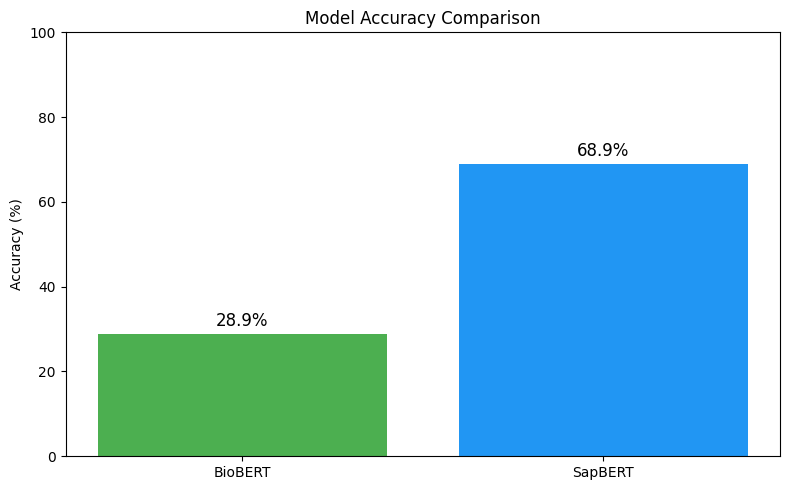

In [9]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("bert_results")


acc_df = df.groupby("model")["match"].mean().reset_index()
acc_df["accuracy (%)"] = acc_df["match"] * 100


plt.figure(figsize=(8, 5))
bars = plt.bar(acc_df["model"], acc_df["accuracy (%)"], color=["#4CAF50", "#2196F3"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


/tmp/ipython-input-10-2360822267.py:5: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x="model", y="similarity", data=df, join=False, color='black', markers='D', scale=1.2, errwidth=0.5)
/tmp/ipython-input-10-2360822267.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x="model", y="similarity", data=df, join=False, color='black', markers='D', scale=1.2, errwidth=0.5)
/tmp/ipython-input-10-2360822267.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  sns.pointplot(x="model", y="similarity", data=df, join=False, color='black', markers='D', scale=1.2, errwidth=0.5)


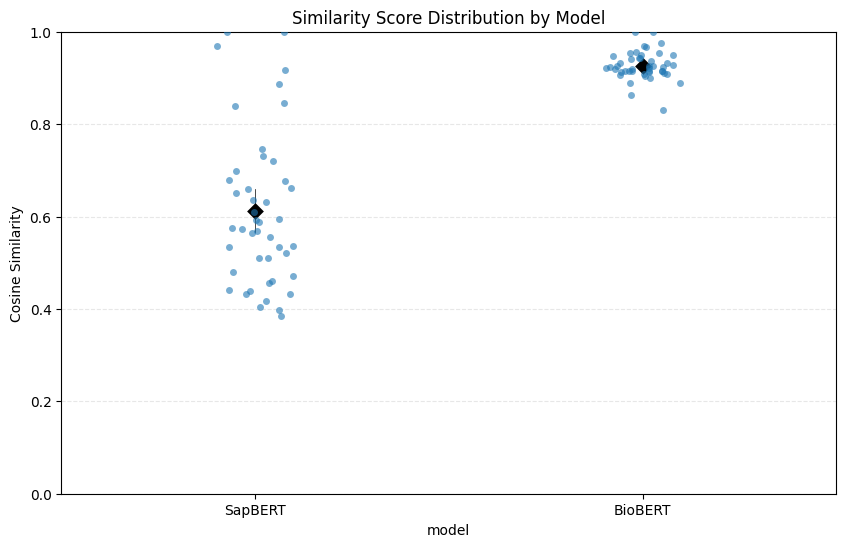

In [10]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.stripplot(x="model", y="similarity", data=df, jitter=True, alpha=0.6)
sns.pointplot(x="model", y="similarity", data=df, join=False, color='black', markers='D', scale=1.2, errwidth=0.5)
plt.title("Similarity Score Distribution by Model")
plt.ylabel("Cosine Similarity")
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.show()
